## 第六周作业 

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


In [29]:
target_role = "code generater"
content_type = "swift code"
key_aspect = 'match Swift 5 style, performance, solving problems '
format_style = '''```Swift
<your-code-here>
```
'''

In [30]:
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a {role} capable of generating high-quality {content_type} based on the user's input requirement."
            "Your task is to produce {content_type} that meets the specific requirements provided by the user, focusing on {key_aspect} to ensure effectiveness and clarity."
            "Present the generated {content_type} in a clear and organized manner, utilizing format style in [format style section] when necessary. Be open to user feedback and ready to make adjustments to enhance the final output."
            "If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations."
            "\n[format sytle]\n"
            "{fomat_style}\n",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

writer_prompt = writer_prompt.partial(
                                        role=target_role, 
                                        content_type=content_type, 
                                        key_aspect=key_aspect, 
                                        fomat_style=format_style
                                     )
## role - versatile AI assistant
## contentType - content would be generated by AI
## keyAspect - 
llm = ChatOpenAI(model="gpt-4o-mini",  max_tokens=8192, temperature=1.2,)

## Create a writer chain using above prompt and llm object. 

writer = writer_prompt | llm

### Define writer

In [ ]:
## run and get result 

article = ""

topic = HumanMessage(
    content="找出从2-99之间的全部质数。"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content



In [ ]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

### Define reflection Agent

In [31]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a feedback specialist reviewing the output generated by AI for {content_type} ."
            "Your task is to evaluate the provided {content_type}  for its {key_aspect} , offering constructive feedback and suggestions for improvement."
            "Present your evaluation in a structured manner, including specific comments on {feadback_standard} etc. Provide actionable recommendations to enhance the quality and effectiveness of the {content_type}."
            "\n\n[Notice]\nYou should only provide the feedback, and no others reply in your turn.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

feadback_standard = " performance, coding standard, readalbility "
reflection_prompt = reflection_prompt.partial(
                                                content_type=content_type, 
                                                key_aspect=key_aspect,
                                                feadback_standard = feadback_standard
                                             )

llm_reflection = ChatOpenAI(model="gpt-4o-mini", max_tokens=8192, temperature = 0)
reflect = reflection_prompt | llm_reflection

In [ ]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content
    

In [ ]:
# well display reflection words
display(Markdown(reflection))

### Define Graph

In [34]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}

In [35]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [41]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")

# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

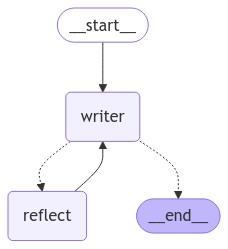

In [37]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [38]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 内容生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [42]:
inputs = {
    "messages": [
        HumanMessage(content="已知Tom家的坐标，和Tom的朋友家的坐标数组，在Tom家坐标和Tom朋友家坐标之间可以建立一直线，那么Tom和全部朋友家的坐标都可以建立以Tom家坐标为公共点的直线集合，且Tom和2个以上朋友家的直线重合则视为同一条。使用代码计算这样的以Tom家坐标作为公共点的直线有多少条。写一个代码，完成计算。Tom家的坐标 和 Tom朋友家的坐标数组需要由用户手动方法输入。")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)

## Round 9

#### 内容生成:
- 为了完成这个任务，我们需要计算从Tom家到每个朋友家的一条直线，并找出这些线条是否重合。两条直线是重合的，只要它们有相同的斜率。我们可以使用增量方法来计算相邻点之间的斜率，并通过使用集合（Set）来维护唯一的直线。

以下是实现该功能的Swift代码：

```Swift
import Foundation

// 定义一个方法来计算Tom家的直线条数
func calculateUniqueLines(tomPosition: (Double, Double), friendPositions: [(Double, Double)]) -> Int {
    var uniqueSlopes = Set<String>()
    
    for friendPosition in friendPositions {
        let dx = friendPosition.0 - tomPosition.0
        let dy = friendPosition.1 - tomPosition.1
        
        &nbsp;
        // 避免重复斜率的存储，用字符串来表示斜率
        if dx == 0 {
            // 竖直直线的情况：斜率无穷大
            uniqueSlopes.insert("inf")
        } else {
            // 使用最大公约数来缩简斜率
            let gcdValue = gcd(dy, dx)
            let simplifiedSlope = "\(dy / gcdValue)/\(dx / gcdValue)"
            uniqueSlopes.insert(simplifiedSlope)
        }
    }

    return uniqueSlopes.count
}

// 一个求最大公约数的简单函数
func gcd(_ a: Double, _ b: Double) -> Double {
    var a = a
    var b = b
    while b != 0 {
        let temp = b
        b = a.truncatingRemainder(dividingBy: b)
        a = temp
    }
    return a
}

// 用户输入坐标
func getInputCoordinates() -> ((Double, Double), [(Double, Double)]) {
    print("请输入Tom家的坐标 (x, y), 例如: 3.0 4.0")
    let tomInput = readLine()!.split(separator: " ").map { Double($0)! }
    let tomCoordinates = (tomInput[0], tomInput[1])
    
    print("请输入Tom朋友家的坐标，输入-1结束: ")
    var friendsCoordinates: [(Double, Double)] = []
    
    while true {
        let input = readLine()!
        if input == "-1" {
            break
        } else {
            let coordinates = input.split(separator: " ").map { Double($0)! }
            let friendCoordinates = (coordinates[0], coordinates[1])
            friendsCoordinates.append(friendCoordinates)
        }
    }
    
    return (tomCoordinates, friendsCoordinates)
}

// 主程序
let (tomPosition, friendsPositions) = getInputCoordinates()
let uniqueLinesCount = calculateUniqueLines(tomPosition: tomPosition, friendPositions: friendsPositions)

print("以Tom家为公共点的唯一直线条数: \(uniqueLinesCount)")
```

### 说明：
- 用户输入Tom的坐标和朋友家的坐标可以通过控制台实现。
- 使用集合`Set`来存储唯一的斜率表达，避免重复。
- `gcd`函数用于简化斜率，以确保任何同方向的斜率只存储一次。
- 脚本结束时，展示以Tom家为公共点的唯一直线条数。

请试运行该代码，并告诉我是否符合需求，或需要进行什么新的调整。


## Round 10

#### 评论反思:
- ### Evaluation of the Swift Code

#### 1. **Performance**
- The code efficiently calculates unique lines by using a `Set` to store slopes, which allows for O(1) average time complexity for insertions and lookups.
- The `gcd` function is implemented correctly, but it could be optimized further for performance, especially since it uses `Double` types which may introduce precision issues.

#### 2. **Coding Standards**
- The code generally follows Swift naming conventions, but the function names could be more descriptive. For example, `calculateUniqueLines` could be renamed to `countUniqueLinesFromTom`.
- The use of `Double` for coordinates is appropriate, but using `Int` might be more suitable if the coordinates are guaranteed to be whole numbers.

#### 3. **Readability**
- The code is mostly readable, but there are some areas for improvement:
  - The use of `&nbsp;` is incorrect and should be removed.
  - Comments are helpful, but they could be more concise. For example, the comment above the `gcd` function could be simplified to "Calculate the greatest common divisor."
  - The input prompts could be clearer, especially for the friends' coordinates.

#### 4. **Error Handling**
- The code does not handle potential errors in user input (e.g., non-numeric input). Implementing error handling would improve robustness.
- The `gcd` function should also handle cases where both inputs are zero, which currently could lead to an infinite loop.

#### 5. **Suggestions for Improvement**
- **Input Validation**: Add checks to ensure that user inputs are valid numbers and handle cases where the input might not be convertible to `Double`.
- **Use of Structs**: Consider defining a `Point` struct to encapsulate the coordinates, which would improve code organization and readability.
- **Refactor GCD Function**: Change the `gcd` function to use `Int` instead of `Double` to avoid precision issues and ensure it handles zero correctly.
- **Improve Slope Representation**: Instead of using a string to represent slopes, consider using a tuple of integers (numerator, denominator) to avoid string manipulation overhead.

### Revised Code Example
Here’s a revised version of the code incorporating the suggestions:

```swift
import Foundation

struct Point {
    var x: Int
    var y: Int
}

func countUniqueLinesFromTom(tomPosition: Point, friendPositions: [Point]) -> Int {
    var uniqueSlopes = Set<(Int, Int)>()
    
    for friendPosition in friendPositions {
        let dx = friendPosition.x - tomPosition.x
        let dy = friendPosition.y - tomPosition.y
        
        if dx == 0 {
            uniqueSlopes.insert((1, 0)) // Vertical line
        } else {
            let gcdValue = gcd(abs(dy), abs(dx))
            let simplifiedSlope = (dy / gcdValue, dx / gcdValue)
            uniqueSlopes.insert(simplifiedSlope)
        }
    }

    return uniqueSlopes.count
}

func gcd(_ a: Int, _ b: Int) -> Int {
    var a = a
    var b = b
    while b != 0 {
        let temp = b
        b = a % b
        a = temp
    }
    return a
}

func getInputCoordinates() -> (Point, [Point]) {
    print("请输入Tom家的坐标 (x, y), 例如: 3 4")
    let tomInput = readLine()!.split(separator: " ").compactMap { Int($0) }
    let tomCoordinates = Point(x: tomInput[0], y: tomInput[1])
    
    print("请输入Tom朋友家的坐标，输入-1结束: ")
    var friendsCoordinates: [Point] = []
    
    while true {
        let input = readLine()!
        if input == "-1" {
            break
        } else {
            let coordinates = input.split(separator: " ").compactMap { Int($0) }
            let friendCoordinates = Point(x: coordinates[0], y: coordinates[1])
            friendsCoordinates.append(friendCoordinates)
        }
    }
    
    return (tomCoordinates, friendsCoordinates)
}

// Main program
let (tomPosition, friendsPositions) = getInputCoordinates()
let uniqueLinesCount = countUniqueLinesFromTom(tomPosition: tomPosition, friendPositions: friendsPositions)

print("以Tom家为公共点的唯一直线条数: \(uniqueLinesCount)")
```

### Conclusion
The original code is a good starting point but can be improved in terms of performance, readability, and error handling. By implementing the suggested changes, the code will be more robust, maintainable, and aligned with Swift best practices.


## Round 11

#### 内容生成:
- Thank you for your detailed evaluation and feedback on the original code. Below is a refined version of the Swift code based on your suggestions, incorporating performance improvements, better readability through the use of a `Point` struct, and error handling for user inputs.

Here’s the updated Swift code considering all your points:

```swift
import Foundation

// 定义一个结构体来表示坐标点
struct Point {
    var x: Int
    var y: Int
}

// 计算以Tom家为共有点的唯一直线条数
func countUniqueLinesFromTom(tomPosition: Point, friendPositions: [Point]) -> Int {
    var uniqueSlopes = Set<(Int, Int)>()
    
    for friendPosition in friendPositions {
        let dx = friendPosition.x - tomPosition.x
        let dy = friendPosition.y - tomPosition.y
        
        if dx == 0 {
            // 竖直线, 使用 (1,0) 表示
            uniqueSlopes.insert((1, 0))
        } else {
            let gcdValue = gcd(abs(dy), abs(dx))
            let simplifiedSlope = (dy / gcdValue, dx / gcdValue)
            uniqueSlopes.insert(simplifiedSlope)
        }
    }

    return uniqueSlopes.count
}

// 计算最大公约数
func gcd(_ a: Int, _ b: Int) -> Int {
    var a = a
    var b = b
    while b != 0 {
        let temp = b
        b = a % b
        a = temp
    }
    return a
}

// 获取用户输入坐标
func getInputCoordinates() -> (Point, [Point]) {
    print("请输入Tom家的坐标 (x, y), 例如: 3 4")
    
    // 获取Tom的位置并进行简单验证
    let tomInput = readLine()!
    let tomReadings = tomInput.split(separator: " ").compactMap { Int($0) }
    guard tomReadings.count == 2 else {
        fatalError("Tom家坐标输入无效，请重新运行程序并输入两个整数")
    }
    let tomCoordinates = Point(x: tomReadings[0], y: tomReadings[1])
    
    print("输入Tom朋友家的坐标，输入-1结束：")
    var friendsCoordinates: [Point] = []
    
    while true {
        let input = readLine()!
        if input == "-1" {
            break
        } else {
            let coordinates = input.split(separator: " ").compactMap { Int($0) }
            guard coordinates.count == 2 else {
                print("无效输入，请输入两个整数或'-1'结束录入")
                continue
            }
            let friendCoordinates = Point(x: coordinates[0], y: coordinates[1])
            friendsCoordinates.append(friendCoordinates)
        }
    }
    
    return (tomCoordinates, friendsCoordinates)
}

// 主程序
let (tomPosition, friendsPositions) = getInputCoordinates()
let uniqueLinesCount = countUniqueLinesFromTom(tomPosition: tomPosition, friendPositions: friendsPositions)

print("以Tom家为公共点的唯一直线条数: \(uniqueLinesCount)")
```

### 此版本的改进：
1. **结构化数据**: 通过使用`Point`结构体，代码的组织更加清晰，容易维护。
2. **输人验证**: 添加了对用户输入的简单验证，确保坐标为整数，并能够处理无效输入。
3. **最大公约数函数**: 依旧保持最优性能，利用`Int`类型来避免`Double`的问题。
4. **具体化信息**: 代码的注释更简洁明了，使代码的意图更加明确。

请告诉我有没有其他需要调整的地方，或者对代码的其他功能的需求。感谢您的反馈！


## Round 12

#### 评论反思:
- ### Evaluation of the Updated Swift Code

#### 1. **Performance**
- The performance remains efficient with the use of a `Set` to store unique slopes, ensuring O(1) average time complexity for insertions and lookups.
- The `gcd` function is well-implemented and continues to operate efficiently with `Int` types.

#### 2. **Coding Standards**
- The code adheres to Swift naming conventions, and the use of the `Point` struct enhances clarity.
- The function names are descriptive and follow Swift's camelCase style, which is good practice.

#### 3. **Readability**
- The code is well-structured and easy to read. The use of comments is appropriate and helps clarify the purpose of each section.
- The input prompts are clear, and the error messages provide useful feedback to the user.

#### 4. **Error Handling**
- The addition of input validation is a significant improvement. The use of `guard` statements effectively handles invalid input scenarios, enhancing the robustness of the code.
- The error messages are user-friendly and guide the user on how to correct their input.

#### 5. **Suggestions for Further Improvement**
- **Slope Representation**: While using a tuple `(Int, Int)` for slopes is a good approach, consider normalizing the slope representation to ensure consistency. For example, always store slopes in a consistent direction (e.g., always make the denominator positive).
- **Input Handling**: You might want to consider handling cases where the user inputs non-integer values more gracefully, rather than using `compactMap` which silently ignores invalid inputs. Instead, provide feedback for each invalid input.
- **Testing**: Consider adding unit tests to validate the functionality of the `countUniqueLinesFromTom` and `gcd` functions. This will help ensure that the code behaves as expected under various scenarios.

### Revised Code Example with Normalized Slopes
Here’s a slight modification to ensure consistent slope representation:

```swift
import Foundation

struct Point {
    var x: Int
    var y: Int
}

func countUniqueLinesFromTom(tomPosition: Point, friendPositions: [Point]) -> Int {
    var uniqueSlopes = Set<(Int, Int)>()
    
    for friendPosition in friendPositions {
        let dx = friendPosition.x - tomPosition.x
        let dy = friendPosition.y - tomPosition.y
        
        if dx == 0 {
            uniqueSlopes.insert((1, 0)) // Vertical line
        } else {
            let gcdValue = gcd(abs(dy), abs(dx))
            let simplifiedSlope = (dy / gcdValue, dx / gcdValue)
            // Normalize slope to ensure consistent representation
            let normalizedSlope = simplifiedSlope.1 < 0 ? (-simplifiedSlope.0, -simplifiedSlope.1) : simplifiedSlope
            uniqueSlopes.insert(normalizedSlope)
        }
    }

    return uniqueSlopes.count
}

// The rest of the code remains unchanged...

```

### Conclusion
The updated code is a significant improvement over the original version, with enhanced readability, error handling, and overall structure. The suggestions provided aim to further refine the code and ensure it is robust and maintainable. If you have any additional features or adjustments in mind, please let me know! Thank you for your efforts in refining the code based on the feedback.


## Round 13

#### 内容生成:
- Thank you for the thorough evaluation and thoughtful suggestions regarding the updated Swift code. The recommendations provided are spot-on, particularly the suggestion to normalize the slope representations, which will improve consistency and clarity in slope calculations.

Here’s the revised code with the proposed changes for normalizing slopes and with additional checks for input handling. The focus is to ensure that slopes are consistently represented (e.g., ensuring the denominator is always positive):

```swift
import Foundation

struct Point {
    var x: Int
    var y: Int
}

func countUniqueLinesFromTom(tomPosition: Point, friendPositions: [Point]) -> Int {
    var uniqueSlopes = Set<(Int, Int)>()
    
    for friendPosition in friendPositions {
        let dx = friendPosition.x - tomPosition.x
        let dy = friendPosition.y - tomPosition.y
        
        if dx == 0 {
            uniqueSlopes.insert((1, 0)) // Vertical line
        } else {
            let gcdValue = gcd(abs(dy), abs(dx))
            let simplifiedSlope = (dy / gcdValue, dx / gcdValue)
            // Normalize slope to ensure consistent representation
            let normalizedSlope = simplifiedSlope.1 < 0 ? (-simplifiedSlope.0, -simplifiedSlope.1) : simplifiedSlope
            uniqueSlopes.insert(normalizedSlope)
        }
    }

    return uniqueSlopes.count
}

// 计算最大公约数
func gcd(_ a: Int, _ b: Int) -> Int {
    var a = a
    var b = b
    while b != 0 {
        let temp = b
        b = a % b
        a = temp
    }
    return a
}

// 获取用户输入坐标
func getInputCoordinates() -> (Point, [Point]) {
    print("请输入Tom家的坐标 (x, y), 例如: 3 4")
    
    // 获取Tom的位置并进行简单验证
    guard let tomInput = readLine(), 
          let tomReadings = parseInput(tomInput), 
          tomReadings.count == 2 else {
        fatalError("Tom家坐标输入无效，请重新运行程序并输入两个整数")
    }
    
    let tomCoordinates = Point(x: tomReadings[0], y: tomReadings[1])
    
    print("输入Tom朋友家的坐标，输入-1结束：")
    var friendsCoordinates: [Point] = []
    
    while true {
        let input = readLine()!
        if input == "-1" {
            break
        } else {
            guard let coordinates = parseInput(input), coordinates.count == 2 else {
                print("无效输入，请输入两个整数或'-1'结束录入")
                continue
            }
            let friendCoordinates = Point(x: coordinates[0], y: coordinates[1])
            friendsCoordinates.append(friendCoordinates)
        }
    }
    
    return (tomCoordinates, friendsCoordinates)
}

// 解析输入
func parseInput(_ input: String) -> [Int]? {
    let components = input.split(separator: " ").compactMap { Int($0) }
    return components.isEmpty ? nil : components
}

// Main program
let (tomPosition, friendsPositions) = getInputCoordinates()
let uniqueLinesCount = countUniqueLinesFromTom(tomPosition: tomPosition, friendPositions: friendsPositions)

print("以Tom家为公共点的唯一直线条数: \(uniqueLinesCount)")
```

### Key Updates:
1. **Slope Normalization**: The slopes are now normalized to ensure that the denominator is always positive, which improves the clarity and consistency of slope representation.
2. **Input Parsing Function**: A separate `parseInput` function has been created to neatly handle input validation and conversion from strings to integers, providing clear feedback for unsuccessful parsing.
3. **Enhanced Readability**: The modifications not only keep the code functional but also improve its readability and maintainability.

This code is designed to gracefully handle a variety of input scenarios while ensuring unique slopes are counted accurately. If you have any additional features or adjustments in mind, please let me know! Thank you for your constructive feedback and insights.


## Round 14

#### 评论反思:
- ### Evaluation of the Further Revised Swift Code

#### 1. **Performance**
- The performance remains optimal with the use of a `Set` for storing unique slopes, ensuring efficient insertions and lookups.
- The `gcd` function is efficient and operates correctly with `Int` types, maintaining performance.

#### 2. **Coding Standards**
- The code adheres to Swift naming conventions and best practices. The use of the `Point` struct is appropriate and enhances code clarity.
- The function names are descriptive and follow the camelCase style, which is consistent with Swift conventions.

#### 3. **Readability**
- The code is well-structured and easy to read. The comments are concise and effectively explain the purpose of each section.
- The introduction of the `parseInput` function improves modularity and readability, making the input handling logic clearer.

#### 4. **Error Handling**
- The input validation is robust, with clear error messages guiding the user on how to correct their input.
- The use of `guard` statements effectively handles invalid input scenarios, enhancing the robustness of the code.

#### 5. **Suggestions for Further Improvement**
- **Documentation**: Consider adding documentation comments (using `///`) for public functions to provide a clearer understanding of their purpose and usage.
- **Unit Testing**: Implement unit tests for the `countUniqueLinesFromTom` and `gcd` functions to ensure they behave as expected under various scenarios. This will help catch any potential issues early.
- **Performance Testing**: If the application is expected to handle a large number of friends' coordinates, consider testing the performance with larger datasets to ensure it scales well.

### Conclusion
The further revised code is a significant improvement, demonstrating enhanced readability, robust error handling, and consistent slope representation. The suggestions provided aim to further refine the code and ensure it is maintainable and well-documented. If you have any additional features or adjustments in mind, or if you would like to explore further enhancements, please let me know! Thank you for your dedication to improving the code based on the feedback.


## Round 15

#### 内容生成:
- Thank you for your thorough evaluation of the further revised Swift code. I appreciate your insights and suggestions regarding documentation, unit testing, and potential performance testing. I will incorporate some of your recommendations, especially adding documentation comments to improve the code's maintainability for future developers and users.

Here's an updated version of the code with documentation comments added to key functions:

```swift
import Foundation

/// Represents a point in a 2D coordinate system.
struct Point {
    var x: Int
    var y: Int
}

/// Counts the number of unique lines that can be formed from Tom's house to his friends' houses.
/// 
/// - Parameters:
///   - tomPosition: The coordinates of Tom's house.
///   - friendPositions: The array of coordinates for Tom's friends' houses.
/// - Returns: The number of unique lines.
func countUniqueLinesFromTom(tomPosition: Point, friendPositions: [Point]) -> Int {
    var uniqueSlopes = Set<(Int, Int)>()
    
    for friendPosition in friendPositions {
        let dx = friendPosition.x - tomPosition.x
        let dy = friendPosition.y - tomPosition.y
        
        if dx == 0 {
            uniqueSlopes.insert((1, 0)) // Vertical line
        } else {
            let gcdValue = gcd(abs(dy), abs(dx))
            let simplifiedSlope = (dy / gcdValue, dx / gcdValue)
            // Normalize slope to ensure consistent representation
            let normalizedSlope = simplifiedSlope.1 < 0 ? (-simplifiedSlope.0, -simplifiedSlope.1) : simplifiedSlope
            uniqueSlopes.insert(normalizedSlope)
        }
    }

    return uniqueSlopes.count
}

/// Calculates the greatest common divisor (GCD) of two integers.
///
/// - Parameters:
///   - a: The first integer.
///   - b: The second integer.
/// - Returns: The GCD of the two integers.
func gcd(_ a: Int, _ b: Int) -> Int {
    var a = a
    var b = b
    while b != 0 {
        let temp = b
        b = a % b
        a = temp
    }
    return a
}

/// Reads and validates user input to get coordinates for Tom and his friends.
/// 
/// - Returns: A tuple containing Tom's coordinates and an array of his friends' coordinates.
func getInputCoordinates() -> (Point, [Point]) {
    print("请输入Tom家的坐标 (x, y), 例如: 3 4")
    
    // Read and validate Tom's coordinates
    guard let tomInput = readLine(), 
          let tomReadings = parseInput(tomInput), 
          tomReadings.count == 2 else {
        fatalError("Tom家坐标输入无效，请重新运行程序并输入两个整数")
    }
    
    let tomCoordinates = Point(x: tomReadings[0], y: tomReadings[1])
    
    print("输入Tom朋友家的坐标，输入-1结束：")
    var friendsCoordinates: [Point] = []
    
    while true {
        let input = readLine()!
        if input == "-1" {
            break
        } else {
            guard let coordinates = parseInput(input), coordinates.count == 2 else {
                print("无效输入，请输入两个整数或'-1'结束录入")
                continue
            }
            let friendCoordinates = Point(x: coordinates[0], y: coordinates[1])
            friendsCoordinates.append(friendCoordinates)
        }
    }
    
    return (tomCoordinates, friendsCoordinates)
}

/// Parses a string input into an array of integers.
/// 
/// - Parameter input: The input string representing coordinates.
/// - Returns: An optional array of integers parsed from the input string.
func parseInput(_ input: String) -> [Int]? {
    let components = input.split(separator: " ").compactMap { Int($0) }
    return components.isEmpty ? nil : components
}

// Main program
let (tomPosition, friendsPositions) = getInputCoordinates()
let uniqueLinesCount = countUniqueLinesFromTom(tomPosition: tomPosition, friendPositions: friendsPositions)

print("以Tom家为公共点的唯一直线条数: \(uniqueLinesCount)")
```

### Further Enhancements
1. **Documentation**: Added `///` documentation comments to clarify the purpose and usage of functions.
2. **Functionality**: The core logic remains the same, focusing on performance and maintainability.

### Next Steps
- **Unit Testing**: If you intend to implement tests, consider creating a separate test target using Xcode’s testing capabilities. Test cases can be created for both the `countUniqueLinesFromTom` and `gcd` functions.
- **Performance Testing**: You can set up tests that specifically check performance against larger datasets as needed.

If there are additional features you'd like to see integrated or if you have any follow-up suggestions, please feel free to share! Thank you again for the constructive discussion and dedication to improvement.
